# 뉴스 카테고리 다중분류 프로젝트

본인:  
- Multinominal Naive Bayes
- Support Vector Machine
- Gradient Boosting Classifier

나머지 팀원:  
- Logistic Regression
- Complement Naive Bayes Classifier(CNB)
- Decision Tree
- Random Forest
- Voting
- 1-D CNN  

위의 모델들로 vocab size에 따른 분류 성능을 비교한다.  
<br>

---

**담당 모델 수정**  
- 영석님: voting  
- 지연님: 1D-CNN  
---
<br>

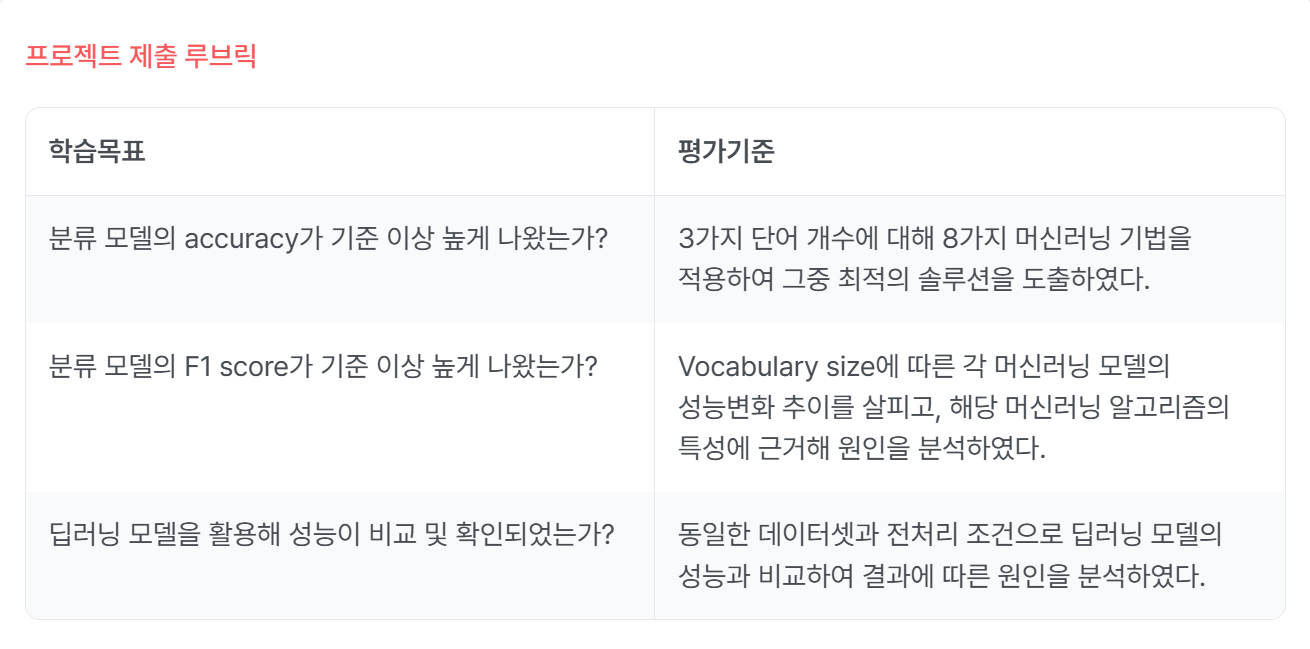

# 라이브러리 및 데이터 로드

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import reuters
import time
from tqdm import tqdm

# Sklearn(ML) 관련 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# TensorFlow/Keras(DL) 관련 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2) # num_words 일단 미지정

# word index 사전
word_index = reuters.get_word_index()

# 0, 1, 2는 pad, sos, unk 토큰이므로 이후의 토큰들에 대해 3을 더해줘야 한다.
index_to_word = {index + 3 : word for word, index in word_index.items()}
index_to_word[0] = "<pad>"
index_to_word[1] = "<sos>"
index_to_word[2] = "<unk>"

# 디코딩
def decode_review(encoded):
    return " ".join(index_to_word.get(i, "<unk>") for i in encoded)

train_texts_all = [decode_review(seq) for seq in x_train]
test_texts_all = [decode_review(seq) for seq in x_test]

# sample 확인
print(train_texts_all[:3])
print(test_texts_all[:3])

['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3", '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the 

# 가설
## **num_words에 따라 모델별 성능이 달라질 것이다.**

# 모델 학습 함수 정의
- 아래는 기존 코드를 정리해서 함수화를 마친 코드이며, 결과 분석 단계에서 GradientBoosting 모델은 기존에 학습 완료했었던 데이터를 사용했습니다.  
- GB vocab 30000은 학습 소요 시간이 10시간이 넘는 것으로 나와서 기록하지 않기로 했습니다.

In [9]:
def run_experiments(train_texts, test_texts, y_train, y_test,
                    num_words_list=[1000, 3000, 5000, 10000, 20000, 30000]):
    """
    다양한 어휘 사전 크기(num_words)에 대해 ML 모델을 학습하고 평가하는 함수입니다.

    Args:
        train_texts: 학습 텍스트 리스트
        test_texts: 테스트 텍스트 리스트
        y_train: 학습 레이블
        y_test: 테스트 레이블
        num_words_list: 실험할 단어 개수 리스트

    Returns:
        결과 데이터프레임 (Num Words, Model, Accuracy, F1 Score)
    """

    # ['word1', 'word2'] -> 'word1 word2' 로 변환
    train_texts = [" ".join(map(str, text)) for text in train_texts]
    test_texts = [" ".join(map(str, text)) for text in test_texts]

    # 클래스 개수 확인
    num_classes = len(np.unique(y_train))
    print(f"[INFO] 데이터 확인 완료. 총 클래스 개수: {num_classes}")

    results = []

    # === 실험 루프 시작 ===
    for num_words in num_words_list:
        print(f"\n{'='*25} num_words = {num_words} {'='*25}")
        loop_start_time = time.time()

        print(f"학습 시작...")

        # TF-IDF 벡터화
        vectorizer = TfidfVectorizer(max_features=num_words)
        X_train_tfidf = vectorizer.fit_transform(train_texts)
        X_test_tfidf = vectorizer.transform(test_texts)

        # 모델 정의
        clf_lr = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
        clf_cnb = ComplementNB()

        models = {
            "MultinomialNB": MultinomialNB(),
            "LinearSVM": LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42),
            #"GradientBoosting": GradientBoostingClassifier(random_state=42, verbose=0),
            "LogisticRegression": clf_lr,
            "ComplementNB": clf_cnb,
            "DecisionTree": DecisionTreeClassifier(random_state=42),
            "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0),
            "Voting (LR+CNB)": VotingClassifier(
                estimators=[('lr', clf_lr), ('cnb', clf_cnb)],
                voting='hard',
                n_jobs=-1
            )
        }

        # 학습 및 평가 루프
        for model_name, model in tqdm(models.items(), desc="Training Sklearn Models"):
            model_start = time.time()

            # 희소 행렬 지원 여부에 따른 처리
            if model_name in ["GradientBoosting", "RandomForest", "DecisionTree"]:
                X_train_input = X_train_tfidf.toarray()
                X_test_input = X_test_tfidf.toarray()
            else:
                X_train_input = X_train_tfidf
                X_test_input = X_test_tfidf

            model.fit(X_train_input, y_train)
            preds = model.predict(X_test_input)

            acc = accuracy_score(y_test, preds)
            f1 = f1_score(y_test, preds, average="macro")

            results.append([num_words, model_name, acc, f1])

            model_time = time.time() - model_start
            print(f"  - {model_name:20s}: Acc={acc:.4f}, F1={f1:.4f} ({model_time:.1f}s)")


    # === 결과 정리 및 반환 ===
    df_results = pd.DataFrame(results, columns=["Num Words", "Model", "Accuracy", "F1 Score"])
    return df_results

In [26]:
def run_experiments_cnn(train_texts, test_texts, y_train, y_test,
                        num_words_list=[1000, 3000, 5000, 10000, 20000, 30000],
                        maxlen=150, embedding_dim=128, epochs=10, batch_size=64):
    """
    다양한 vocab_size(num_words)에 대해 1D-CNN 모델을 학습하고 평가하는 함수입니다.

    Args:
        train_texts: 학습 텍스트 (원본 토큰 리스트 또는 문자열 리스트)
        test_texts: 테스트 텍스트
        y_train: 학습 레이블
        y_test: 테스트 레이블
        num_words_list: 실험할 vocab_size 리스트
        maxlen: 패딩 길이
        embedding_dim: 임베딩 차원
        epochs: 모델 학습 에포크 수
        batch_size: 배치 크기

    Returns:
        결과 DataFrame: Num Words, Model, Accuracy, F1 Score
    """

    # ['word1','word2'] → 'word1 word2' 로 변환
    train_texts = [" ".join(map(str, t)) for t in train_texts]
    test_texts = [" ".join(map(str, t)) for t in test_texts]

    num_classes = len(np.unique(y_train))
    print(f"[INFO] 클래스 개수: {num_classes}")

    results = []
    total_loops = len(num_words_list)
    overall_start = time.time()  # 전체 실험 시작 시간

    for i, num_words in enumerate(num_words_list):
        print(f"\n{'='*25} num_words = {num_words} ({i+1}/{total_loops}) {'='*25}")
        loop_start = time.time()

        # --------------------------
        # 1) 토크나이징 및 패딩
        # --------------------------
        tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
        tokenizer.fit_on_texts(train_texts)

        X_train_seq = tokenizer.texts_to_sequences(train_texts)
        X_test_seq = tokenizer.texts_to_sequences(test_texts)

        X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
        X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

        # --------------------------
        # 2) 레이블 원-핫 변환
        # --------------------------
        y_train_cat = to_categorical(y_train, num_classes=num_classes)
        y_test_cat = to_categorical(y_test, num_classes=num_classes)

        # --------------------------
        # 3) 1D-CNN 모델 구성
        # --------------------------
        model = Sequential([
            Embedding(input_dim=num_words,
                      output_dim=embedding_dim,
                      input_length=maxlen),
            Dropout(0.3),
            Conv1D(filters=128, kernel_size=5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        # --------------------------
        # 4) 학습
        # --------------------------
        model.fit(X_train_pad, y_train_cat,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.1,
                  verbose=0)

        # --------------------------
        # 5) 평가
        # --------------------------
        preds_prob = model.predict(X_test_pad, verbose=0)
        preds = np.argmax(preds_prob, axis=1)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        results.append([num_words, "1D-CNN", acc, f1])

        # --------------------------
        # 6) 시간 출력
        # --------------------------
        loop_time = time.time() - loop_start
        elapsed_total = time.time() - overall_start
        remaining_loops = total_loops - (i + 1)
        avg_time_per_loop = elapsed_total / (i + 1)
        est_remaining = remaining_loops * avg_time_per_loop

        print(f"  - 1D-CNN: Acc={acc:.4f}, F1={f1:.4f}")
        print(f"    Loop time: {loop_time:.1f}s | Estimated remaining: {est_remaining:.1f}s")

    # --------------------------
    # 7) DataFrame으로 정리
    # --------------------------
    df_results = pd.DataFrame(results, columns=["Num Words", "Model", "Accuracy", "F1 Score"])
    return df_results


# 모델 학습

In [7]:
# GPU 설정 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 증가를 허용하도록 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [10]:
# 모델 학습
df_final_results = run_experiments(x_train, x_test, y_train, y_test)

[INFO] 데이터 확인 완료. 총 클래스 개수: 46

========================= num_words = 1000 =========================
학습 시작...


Training Sklearn Models:   0%|          | 0/7 [00:00<?, ?it/s]

  - MultinomialNB       : Acc=0.7177, F1=0.2117 (0.0s)


Training Sklearn Models:  29%|██▊       | 2/7 [00:01<00:04,  1.11it/s]

  - LinearSVM           : Acc=0.8117, F1=0.6077 (1.8s)


Training Sklearn Models:  43%|████▎     | 3/7 [00:06<00:09,  2.38s/it]

  - LogisticRegression  : Acc=0.7921, F1=0.4292 (4.5s)
  - ComplementNB        : Acc=0.7404, F1=0.2942 (0.0s)


Training Sklearn Models:  71%|███████▏  | 5/7 [00:10<00:04,  2.35s/it]

  - DecisionTree        : Acc=0.6825, F1=0.3820 (4.6s)


Training Sklearn Models:  86%|████████▌ | 6/7 [00:18<00:03,  3.94s/it]

  - RandomForest        : Acc=0.7747, F1=0.4441 (8.0s)


Training Sklearn Models: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

  - Voting (LR+CNB)     : Acc=0.7591, F1=0.3198 (3.2s)

========================= num_words = 3000 =========================
학습 시작...



Training Sklearn Models:   0%|          | 0/7 [00:00<?, ?it/s]

  - MultinomialNB       : Acc=0.6981, F1=0.1629 (0.0s)


Training Sklearn Models:  29%|██▊       | 2/7 [00:02<00:05,  1.04s/it]

  - LinearSVM           : Acc=0.8268, F1=0.6797 (2.0s)


Training Sklearn Models:  43%|████▎     | 3/7 [00:06<00:10,  2.64s/it]

  - LogisticRegression  : Acc=0.8059, F1=0.5143 (4.9s)
  - ComplementNB        : Acc=0.7658, F1=0.4513 (0.0s)


Training Sklearn Models:  71%|███████▏  | 5/7 [00:15<00:07,  3.61s/it]

  - DecisionTree        : Acc=0.6995, F1=0.4420 (8.8s)


Training Sklearn Models:  86%|████████▌ | 6/7 [00:26<00:05,  5.73s/it]

  - RandomForest        : Acc=0.7676, F1=0.4546 (11.2s)


Training Sklearn Models: 100%|██████████| 7/7 [00:32<00:00,  4.58s/it]

  - Voting (LR+CNB)     : Acc=0.7756, F1=0.4170 (5.1s)

========================= num_words = 5000 =========================
학습 시작...



Training Sklearn Models:   0%|          | 0/7 [00:00<?, ?it/s]

  - MultinomialNB       : Acc=0.6834, F1=0.1320 (0.0s)


Training Sklearn Models:  29%|██▊       | 2/7 [00:01<00:04,  1.01it/s]

  - LinearSVM           : Acc=0.8237, F1=0.6726 (1.9s)


Training Sklearn Models:  43%|████▎     | 3/7 [00:07<00:11,  2.85s/it]

  - LogisticRegression  : Acc=0.8028, F1=0.5050 (5.4s)
  - ComplementNB        : Acc=0.7707, F1=0.4715 (0.0s)


Training Sklearn Models:  71%|███████▏  | 5/7 [00:20<00:09,  4.92s/it]

  - DecisionTree        : Acc=0.7021, F1=0.4448 (13.3s)


Training Sklearn Models:  86%|████████▌ | 6/7 [00:35<00:07,  7.67s/it]

  - RandomForest        : Acc=0.7587, F1=0.4373 (14.8s)


Training Sklearn Models: 100%|██████████| 7/7 [00:41<00:00,  5.86s/it]

  - Voting (LR+CNB)     : Acc=0.7765, F1=0.4291 (5.5s)

========================= num_words = 10000 =========================
학습 시작...



Training Sklearn Models:   0%|          | 0/7 [00:00<?, ?it/s]

  - MultinomialNB       : Acc=0.6652, F1=0.1012 (0.0s)


Training Sklearn Models:  29%|██▊       | 2/7 [00:02<00:06,  1.38s/it]

  - LinearSVM           : Acc=0.8281, F1=0.6845 (2.7s)


Training Sklearn Models:  43%|████▎     | 3/7 [00:11<00:17,  4.29s/it]

  - LogisticRegression  : Acc=0.7979, F1=0.4823 (8.4s)
  - ComplementNB        : Acc=0.7738, F1=0.4948 (0.0s)


Training Sklearn Models:  71%|███████▏  | 5/7 [00:31<00:15,  7.57s/it]

  - DecisionTree        : Acc=0.6972, F1=0.4362 (20.6s)


Training Sklearn Models:  86%|████████▌ | 6/7 [00:55<00:12, 12.04s/it]

  - RandomForest        : Acc=0.7556, F1=0.4250 (23.5s)


Training Sklearn Models: 100%|██████████| 7/7 [01:03<00:00,  9.00s/it]

  - Voting (LR+CNB)     : Acc=0.7707, F1=0.4139 (7.7s)

========================= num_words = 20000 =========================
학습 시작...



Training Sklearn Models:   0%|          | 0/7 [00:00<?, ?it/s]

  - MultinomialNB       : Acc=0.6278, F1=0.0820 (0.0s)


Training Sklearn Models:  29%|██▊       | 2/7 [00:04<00:12,  2.48s/it]

  - LinearSVM           : Acc=0.8255, F1=0.6786 (4.9s)


Training Sklearn Models:  43%|████▎     | 3/7 [00:17<00:26,  6.58s/it]

  - LogisticRegression  : Acc=0.7965, F1=0.4773 (12.3s)
  - ComplementNB        : Acc=0.7680, F1=0.4619 (0.0s)


Training Sklearn Models:  71%|███████▏  | 5/7 [00:50<00:23, 11.93s/it]

  - DecisionTree        : Acc=0.6981, F1=0.4388 (32.8s)


Training Sklearn Models:  86%|████████▌ | 6/7 [01:30<00:19, 19.93s/it]

  - RandomForest        : Acc=0.7453, F1=0.3961 (40.5s)


Training Sklearn Models: 100%|██████████| 7/7 [01:43<00:00, 14.74s/it]

  - Voting (LR+CNB)     : Acc=0.7667, F1=0.3912 (12.5s)

========================= num_words = 30000 =========================
학습 시작...



Training Sklearn Models:   0%|          | 0/7 [00:00<?, ?it/s]

  - MultinomialNB       : Acc=0.6104, F1=0.0723 (0.0s)


Training Sklearn Models:  29%|██▊       | 2/7 [00:03<00:08,  1.71s/it]

  - LinearSVM           : Acc=0.8272, F1=0.6830 (3.4s)


Training Sklearn Models:  43%|████▎     | 3/7 [00:18<00:29,  7.40s/it]

  - LogisticRegression  : Acc=0.7956, F1=0.4742 (15.4s)
  - ComplementNB        : Acc=0.7600, F1=0.4407 (0.1s)


Training Sklearn Models:  71%|███████▏  | 5/7 [00:58<00:28, 14.20s/it]

  - DecisionTree        : Acc=0.6923, F1=0.4317 (39.8s)


Training Sklearn Models:  86%|████████▌ | 6/7 [01:51<00:24, 24.99s/it]

  - RandomForest        : Acc=0.7409, F1=0.4192 (52.8s)


Training Sklearn Models: 100%|██████████| 7/7 [02:07<00:00, 18.21s/it]

  - Voting (LR+CNB)     : Acc=0.7587, F1=0.3629 (16.1s)


In [28]:
# 모델 학습 (1D-CNN)
df_cnn = run_experiments_cnn(
    x_train, x_test,
    y_train, y_test,
    num_words_list=[1000, 3000, 5000, 10000, 20000, 30000],
    epochs=10
)

df_cnn

[INFO] 클래스 개수: 46

========================= num_words = 1000 (1/6) =========================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  - 1D-CNN: Acc=0.7582, F1=0.2804
    Loop time: 22.7s | Estimated remaining: 113.3s

========================= num_words = 3000 (2/6) =========================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  - 1D-CNN: Acc=0.7547, F1=0.3513
    Loop time: 15.0s | Estimated remaining: 75.4s

========================= num_words = 5000 (3/6) =========================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  - 1D-CNN: Acc=0.7578, F1=0.3468
    Loop time: 15.5s | Estimated remaining: 53.2s

========================= num_words = 10000 (4/6) =========================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  - 1D-CNN: Acc=0.7547, F1=0.3631
    Loop time: 16.2s | Estimated remaining: 34.7s

========================= num_words = 20000 (5/6) =========================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  - 1D-CNN: Acc=0.7645, F1=0.3955
    Loop time: 15.3s | Estimated remaining: 16.9s

========================= num_words = 30000 (6/6) =========================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  - 1D-CNN: Acc=0.7591, F1=0.4191
    Loop time: 19.4s | Estimated remaining: 0.0s


,Num Words,Model,Accuracy,F1 Score
0,1000,1D-CNN,0.758237,0.280382
1,3000,1D-CNN,0.754675,0.351280
2,5000,1D-CNN,0.757792,0.346800
3,10000,1D-CNN,0.754675,0.363067
4,20000,1D-CNN,0.764470,0.395513
5,30000,1D-CNN,0.759127,0.419130


In [30]:
# GradientBoosting 결과 로드 및 concat
gb = pd.read_csv("./Data/gb.csv")

ml_cnn_df = pd.concat([df_final_results, gb, df_cnn], axis=0, ignore_index=True)

# 결과 출력
print("\n[Final Results]")
print(ml_cnn_df.sort_values(by=["Num Words", "F1 Score"], ascending=[True, False]))


[Final Results]
    Num Words               Model  Accuracy  F1 Score
1        1000           LinearSVM  0.811665  0.607671
5        1000        RandomForest  0.774711  0.444068
2        1000  LogisticRegression  0.792075  0.429199
46       1000    GradientBoosting  0.743500  0.400500
4        1000        DecisionTree  0.682547  0.382016
6        1000     Voting (LR+CNB)  0.759127  0.319789
3        1000        ComplementNB  0.740427  0.294183
47       1000              1D-CNN  0.758237  0.280382
0        1000       MultinomialNB  0.717720  0.211673
8        3000           LinearSVM  0.826803  0.679713
42       3000    GradientBoosting  0.767142  0.567806
9        3000  LogisticRegression  0.805877  0.514313
12       3000        RandomForest  0.767587  0.454623
10       3000        ComplementNB  0.765806  0.451319
11       3000        DecisionTree  0.699466  0.442043
13       3000     Voting (LR+CNB)  0.775601  0.417031
48       3000              1D-CNN  0.754675  0.351280
7        30

In [31]:
#ml_cnn_df.to_csv("./Data/acc_f1.csv", index=False)

# 최종 결과 시각화 및 분석

## 시각화

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

final_df = pd.read_csv("./Data/acc_f1.csv")
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Num Words  53 non-null     int64  
 1   Model      53 non-null     object 
 2   Accuracy   53 non-null     float64
 3   F1 Score   53 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ KB


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# 그래프 그리기 함수 정의
def draw_metric_grid(dataframe, metric_name, n_cols=3):
    """
    dataframe: 데이터프레임
    metric_name: 그릴 지표 컬럼명 ('Accuracy' 또는 'F1 Score')
    n_cols: 가로로 배치할 그래프 개수 (기본 3개)
    """
    models = dataframe['Model'].unique()
    n_models = len(models)
    n_rows = math.ceil(n_models / n_cols)

    # 전체 그림 생성
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten() # 2차원 배열을 1차원으로 펼침

    # 그래프 제목 설정
    fig.suptitle(f'{metric_name} vs Num Words by Model', fontsize=20, y=1.02)

    for i, model in enumerate(models):
        ax = axes[i]
        subset = dataframe[dataframe['Model'] == model]

        # X축 정렬 (Num Words 기준)
        subset = subset.sort_values('Num Words')

        # 선 그래프 그리기
        # x축을 문자열로 변환하여 간격을 일정하게 유지
        ax.plot(subset['Num Words'].astype(str), subset[metric_name],
                marker='o', linestyle='-', linewidth=2, markersize=6)

        # 스타일 설정
        ax.set_title(model, fontsize=14, fontweight='bold')
        ax.set_ylabel(metric_name)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Y축 범위 여유 있게 설정
        y_min, y_max = subset[metric_name].min(), subset[metric_name].max()
        margin = (y_max - y_min) * 0.2 if y_max != y_min else 0.01
        ax.set_ylim(y_min - margin, y_max + margin)

    # 남는 서브플롯 제거
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

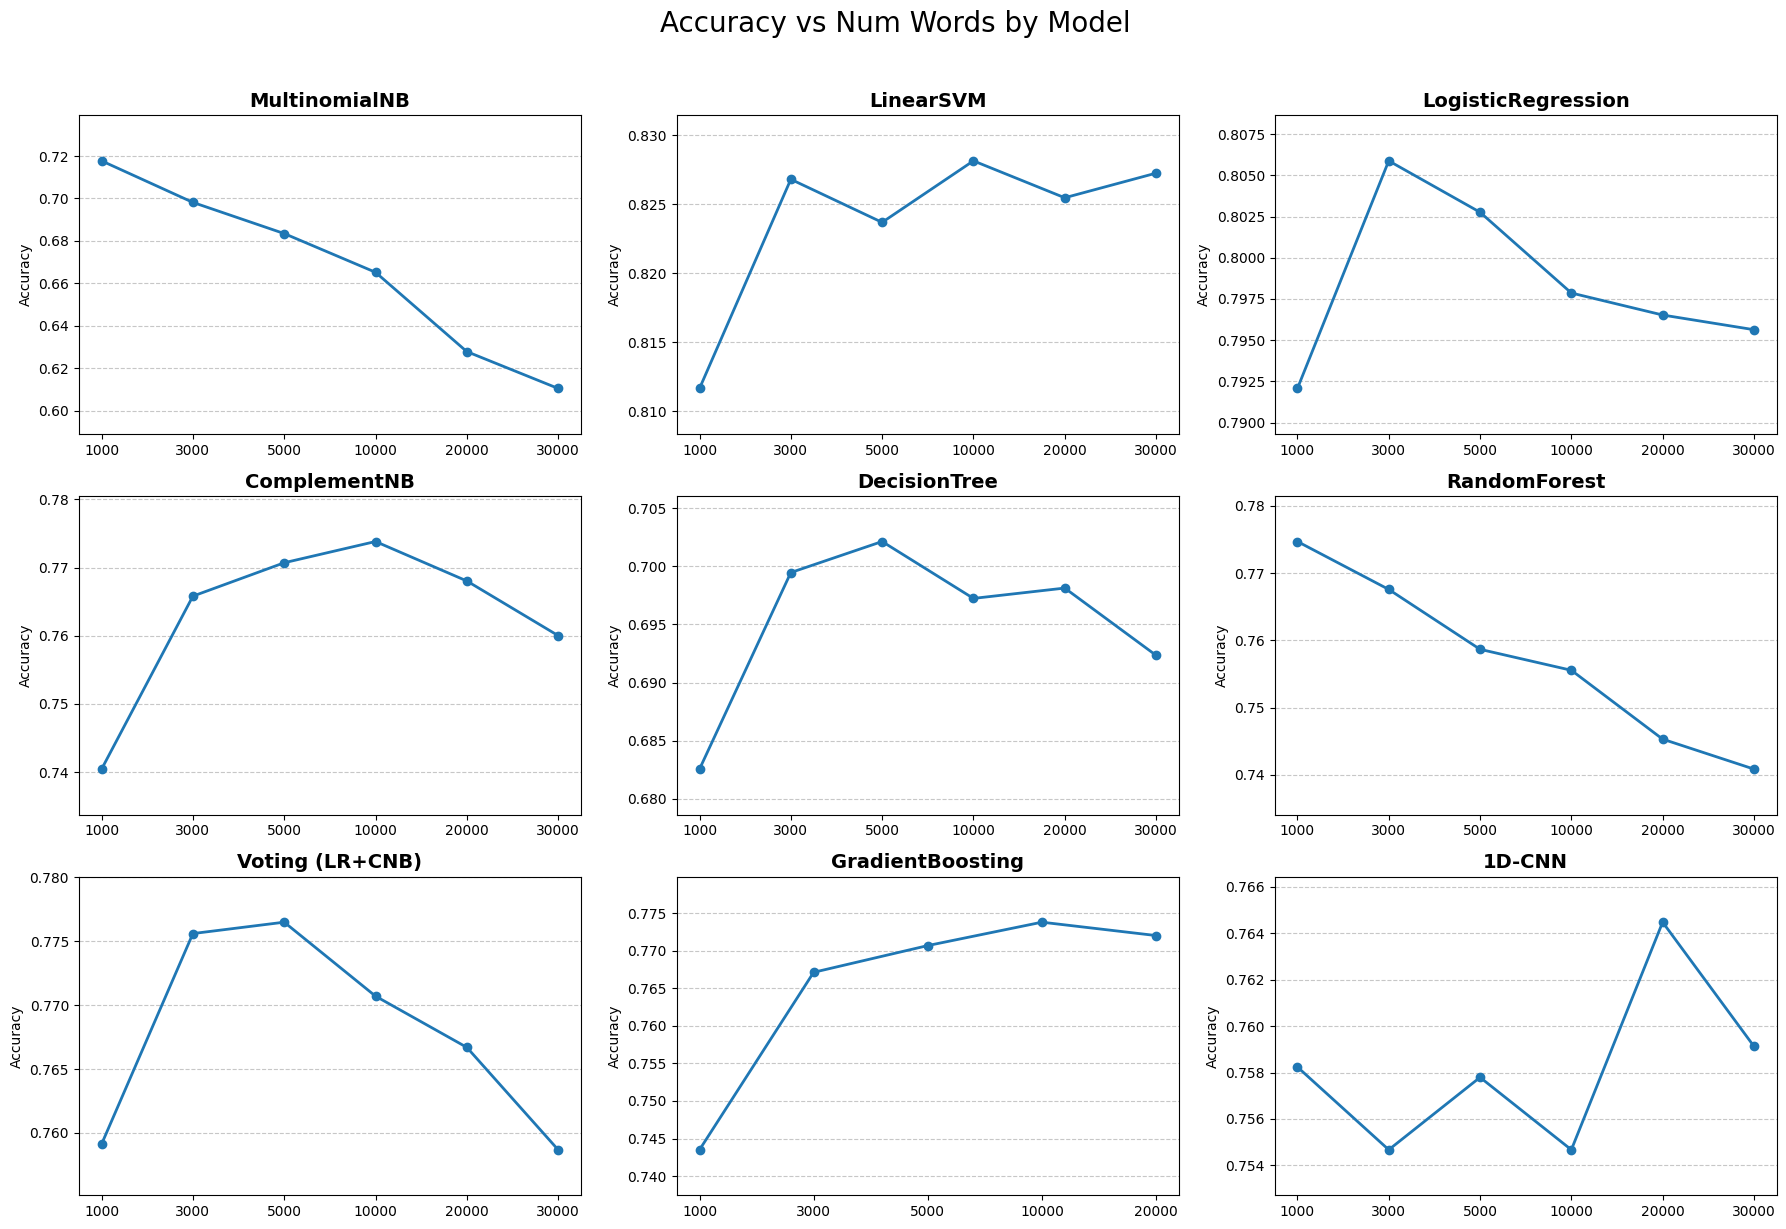

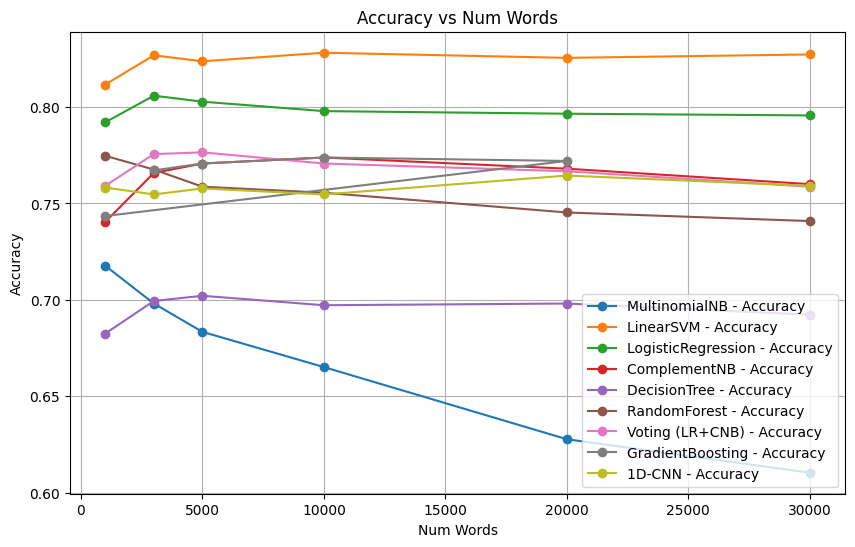

In [36]:
# Acc
draw_metric_grid(final_df, 'Accuracy', n_cols=3)

plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["Accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

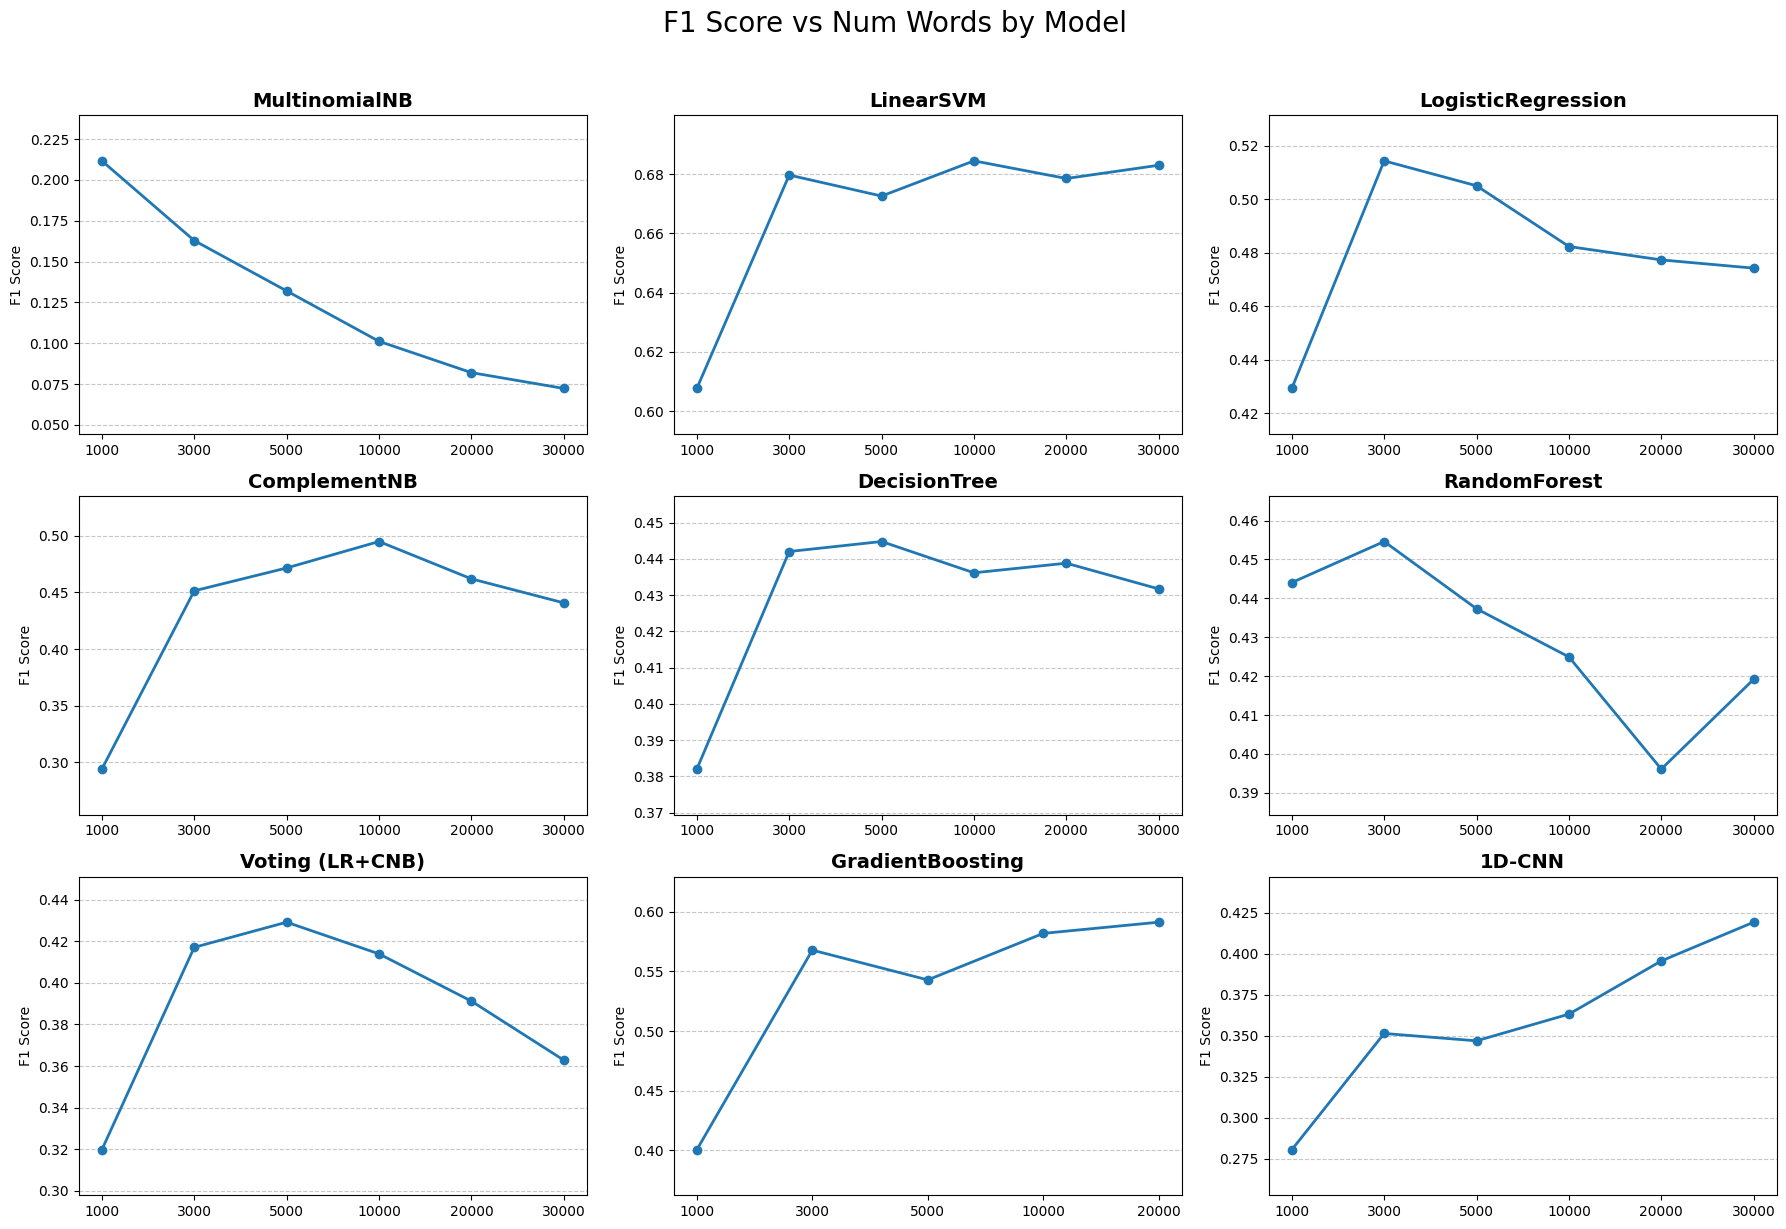

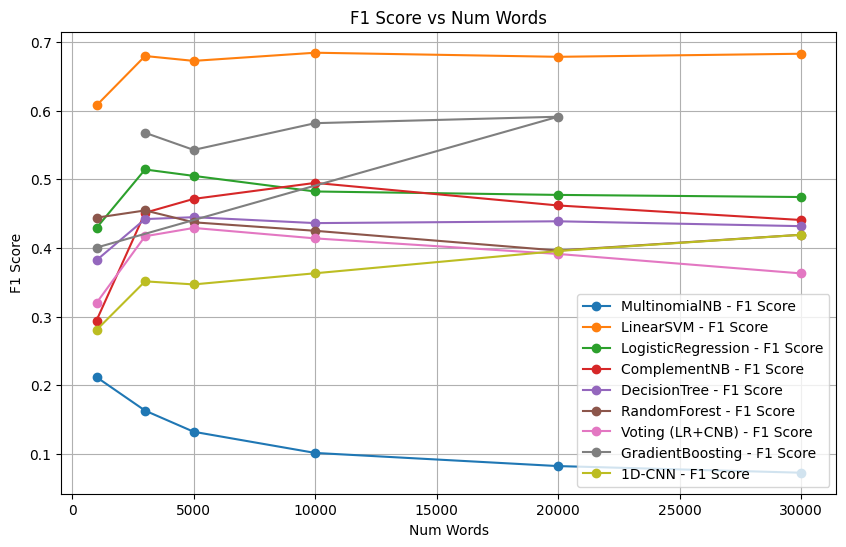

In [37]:
# F1 score
draw_metric_grid(final_df, 'F1 Score', n_cols=3)

plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["F1 Score"], marker='o', label=f"{model_name} - F1 Score")

plt.title("F1 Score vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

## 분석

### 1. 나이브 베이즈 모델  
**MultinomialNB** 모델은 num_words가 커질수록 성능이 크게 하락한다. 하지만, 같은 나이브베이즈 모델인 **ComplementNB는** 성능이 안정적으로 유지되는데, 그 이유는?  
- 나이브 베이즈는 "모든 단어가 서로 독립적"이라고 가정해서 확률을 계산하므로, 단어 수가 많아지면 희소한 단어들이 노이즈가 되어 성능이 하락한다.  
- ComplementNB는 희소 단어의 가중치를 보정하는 **정규화** 과정이 포함되어 있기 때문에, 단어 수가 늘어나면서 노이즈가 많아져도 강건한 성능을 보인다.  
<br>

### 2. 선형 모델  
LinearSVM의 경우 num_words가 커져도 성능이 안정적으로 유지되거나 상승한다. 하지만 같은 선형 모델인 Logistic Regression은 성능이 하락한다. 그 이유는?  
- SVM의 결정 경계는 경계 근처에 있는 소수의 서포트 벡터에 의해 결정되어서 **노이즈는 결정 경계에 영향을 주지 않는다.**
- 반면, 로지스틱은 모든 data points의 오차를 최소화 하는 방식이므로 노이즈들이 모두 반영되어 성능이 하락하게 된다.  
<br>

### 3. 트리 기반 모델
Decision Tree 모델의 경우 num_words가 커져도 소폭 하락하거나 유지되는데, RandomForest는 성능이 하락한다. 그 이유는?  
- DT는 정보 이득이 가장 높은 단어만 고르기 때문에 나머지 노이즈들은 무시해서 노이즈에 큰 영향을 받지 않는다. (feature selection 느낌)  
- 반면, RF는 여러 개의 트리를 만들어 전체 단어가 아닌 무작위로 일부 단어만 사용해서 학습하므로 num_words가 많아지면 당연히 노이즈를 선택할 확률도 높아지므로 성능이 낮아질 수밖에 없다.  
- 그런데 RF 그래프를 보면 num_words 3만개 구간에서 다시 오르는데, 그 이유는?
    - 단어 수가 매우 많아지면 약하지만 유용한 피처들이 늘어납니다.
    - 랜덤 포레스트는 많은 약한 트리를 모아 작은 신호들을 누적해 최종 성능을 높일 수 있습니다.
    - 그래서 단어 수가 지나치게 많아도 성능이 다시 소폭 상승하는 반등 구간이 생길 수 있습니다.  
- 라고 하는데 뭔가 이해가 확실히 안 가고 애매해서 밤에 다시 보겠습니다.  
<br>